In [5]:
#loading the packages, and the version for the main packages are inclued.
#Please use the same version packages to replicate the project.
# Tensorflow 1.14.0.
# Cuda 10.0 
# skimage 0.15.0.
# scikit-learn 0.21.3.
# keras  2.3.0.
# numpy 1.16.5.
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [2]:
# Set some parameters
# You can make a change for the numbers of pixels and channel regarding to your project. 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# set the train and test path
# Test path usually is used to predict the output for the images
TRAIN_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/train/'
# TEST_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/test/'
TEST_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/imagechunck/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

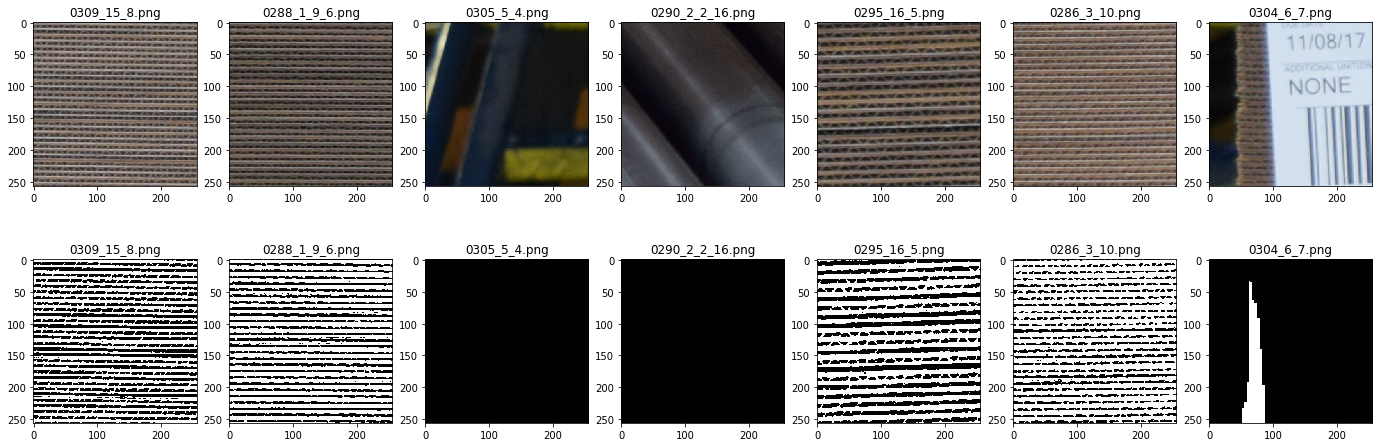

In [3]:
#set the train_image_path and train_mask_path where your images and labels for images are sitting.
# The paths are setted as below:
# train_image_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/image/"
# train_mask_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/label/"
# Radomly sample some data to double check the data quality.
train_image_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/image/"
train_mask_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/label/"
 
image_array = []
 
for root, dirs, files in os.walk(train_image_path): 
    image_array = files

col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(image_array)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(24,8))  
 
for row in range(0,row_size): 
    image_index = 0
    if (row==0): 
        da_path= train_image_path
    else: 
        da_path= train_mask_path
 
    for col in range(0,col_size):
        img = load_img(da_path+image_array[rand_id_array[image_index]])
        ax[row][col].imshow(img)
        ax[row][col].set_title(image_array[rand_id_array[image_index]])
        image_index += 1
plt.show()

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[0]
print(train_ids)
print(test_ids)

li=[x.split('.')[0] for x in os.listdir(os.path.join(TRAIN_PATH, next(os.walk(TRAIN_PATH))[1][1])) ]

lione=[x.split('.')[0] for x in os.listdir(TEST_PATH)]


['image', 'label']
C:/Users/mxie3/Downloads/unet-master/data/membrane/imagechunck/


Get the data
Let's first import all the images and associated masks. 
I downsample both the training and test images to keep things light and manageable,
but we need to keep a record of the original sizes of the test images to upsample 
our predicted masks and create correct run-length encodings later on. 
There are definitely better ways to handle this, but it works fine for now!

In [ ]:
# Get and resize train images and masks
# Set the dtype as np.float32
X_train = np.zeros((len(li), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(li), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(li), total=len(li)):
    path = TRAIN_PATH 
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img/255
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1),dtype=np.float32)
    mask_ = imread(path + '/label/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask/255

    #mask = img_to_array(load_img(path + '/label/' + id_ + '.png', grayscale=True))
    #mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
    #Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(lione), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(lione), total=len(test_ids)):
    path = TEST_PATH 
    img = imread(path + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img/255
print('Done!')

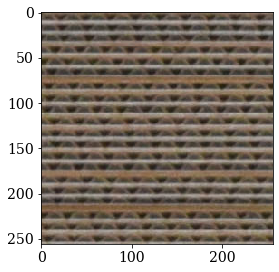

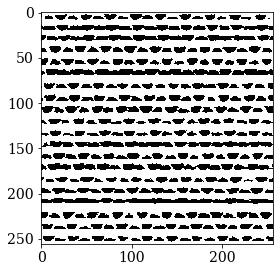

In [38]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Create our Keras metric
Now we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so We tried to implement this. We're by no means certain that this implementation is correct, though! Any assistance in verifying this would be most welcome!
Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [39]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [41]:
# Build U-Net model
# The parameters can be ajusted based upon your project needs
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

# print out the model summary to double check the pramaters for the model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fit model and calculate the running time
import timeit

start = timeit.default_timer()

earlystopper = EarlyStopping(patience=20, verbose=1)

# save the model check point, please note the defaut path is where your jupernotebook running
# For other paramerters such as epochs, batch_size etc., you can ajust them based upon what your project needs.

checkpointer = ModelCheckpoint('model-log080623iou.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=150, 
                    callbacks=[earlystopper, checkpointer])

stop = timeit.default_timer()

print('Time: ', stop - start)  


0.974920928478241
0.10121423750072196


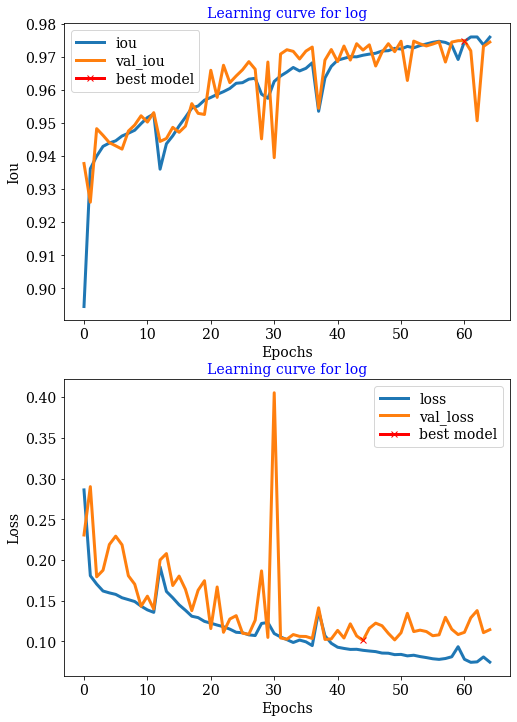

In [43]:
# plot the leaning curve
# you can make a change for legend regarding your project
plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.title("Learning curve for log",fontsize=14, color="blue")
plt.plot(results.history["iou"], label="iou",linewidth=3)
plt.plot(results.history["val_iou"], label="val_iou",linewidth=3)
plt.plot( np.argmax(results.history["val_iou"]), np.max(results.history["val_iou"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Iou",fontsize=14)
plt.legend();
print(np.max(results.history["val_iou"]))

plt.subplot(2,1,2)

plt.title("Learning curve for log",fontsize=14, color="blue")
plt.plot(results.history["loss"], label="loss",linewidth=3)
plt.plot(results.history["val_loss"],label="val_loss",linewidth=3)
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.legend();
print(np.min(results.history["val_loss"]))
#0.8793798685073853 steel
#0.9789779186248779 steel iou
#0.9495388269424438 cardboard
#0.19808801025466047
#0.9162416458129883 homedepot
#0.2886759589485076
#0.9808236360549927 steel
#0.0798869830950235
#0.9931753277778625 log
#0.03263660343830654
#0.9979723691940308 log
#0.008322062255339008
#0.9981222152709961 lognew
#0.00738993662616198
# 0.9748544692993164 cardboard
# 0.10187775430284911
# 0.9351864457130432 homedepot
# 0.2829342065690618
# 0.9801501035690308 steel
# 0.08850873220497026

plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
plt.figure(figsize=(8, 8))
plt.title("Learning curve for steel",fontsize=14, color="blue")
plt.plot(results.history["accuracy"], label="accuracy",linewidth=3)
plt.plot(results.history["val_accuracy"], label="val_accuracy",linewidth=3)
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("log_loss",fontsize=14)
plt.legend();
print(np.max(results.history["val_accuracy"]))
#0.8793798685073853 steel

0.10121423750072196


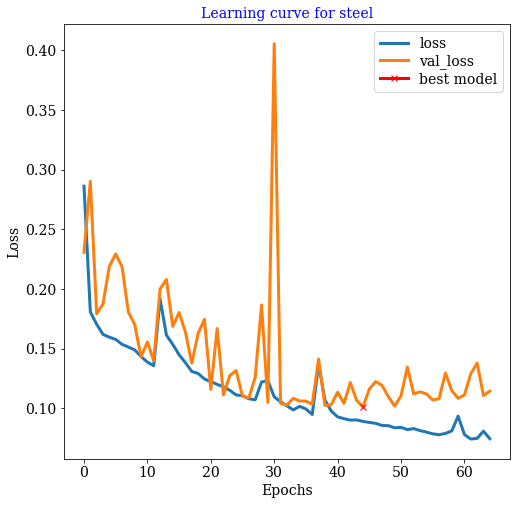

In [44]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
plt.figure(figsize=(8, 8))
plt.title("Learning curve for steel",fontsize=14, color="blue")
plt.plot(results.history["loss"], label="loss",linewidth=3)
plt.plot(results.history["val_loss"],label="val_loss",linewidth=3)
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.legend();
print(np.min(results.history["val_loss"]))
#0.09378293198712456 steel
#0.09734031272371514 steel iou

In [45]:
import os
os.getcwd()

'C:\\Users\\mxie3'

In [ ]:
# Predict on train, val and test
#model = load_model('model-dsbowl2018-2.h5',custom_objects={'iou': iou})
# when you are trying to predict new images, please make sure reload the test data set
# you just need to make a change for test_path
model = load_model(r'C:\Users\mxie3\model-log080623iou.h5',custom_objects={'iou': iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

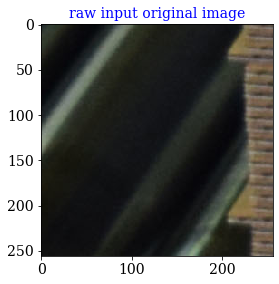

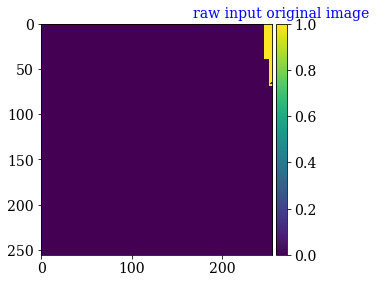

In [49]:
# Perform a sanity check on some random training samples
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
ix = random.randint(0, len(preds_train_t))
# fig = plt.figure(figsize=(6, 6))
imshow(X_train[ix])
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
# fig = plt.figure(figsize=(6, 6))
imshow(np.squeeze(Y_train[ix]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()

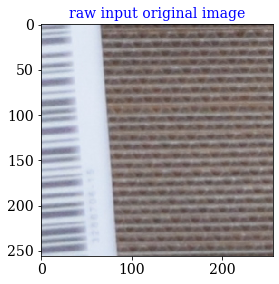

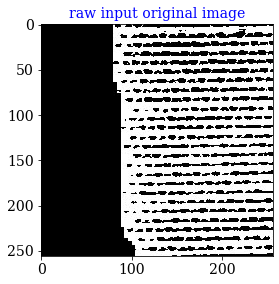

In [50]:
# Perform a sanity check on some random validation samples
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()

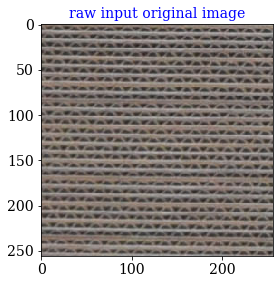

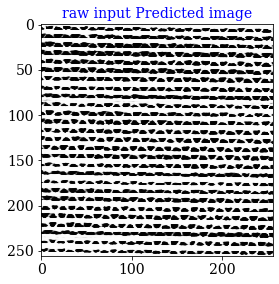

In [51]:
# Perform some checks on test images
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
n = random.randint(0, len(test_ids))
imshow(np.squeeze(X_test[n]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
imshow(np.squeeze(preds_test[n]))
plt.title("raw input Predicted image",fontsize=14, color="blue")
plt.show()

In [115]:
#create two folders, one for original images, one for predicted iamges
import os
os.mkdir('D:/carboardin/')
os.mkdir('D:/carboardout/')

In [ ]:
#batch predict the results
import skimage.io as io
for n, id_ in tqdm(enumerate(lione), total=len(test_ids)):
    path = TEST_PATH 
    img=np.squeeze(X_test[n])
    io.imsave('D:/carboardin/' + str(id_)+'.png', img)
    pred=np.squeeze(preds_test[n])
    io.imsave('D:/carboardout/' + str(id_)+'.png', pred)


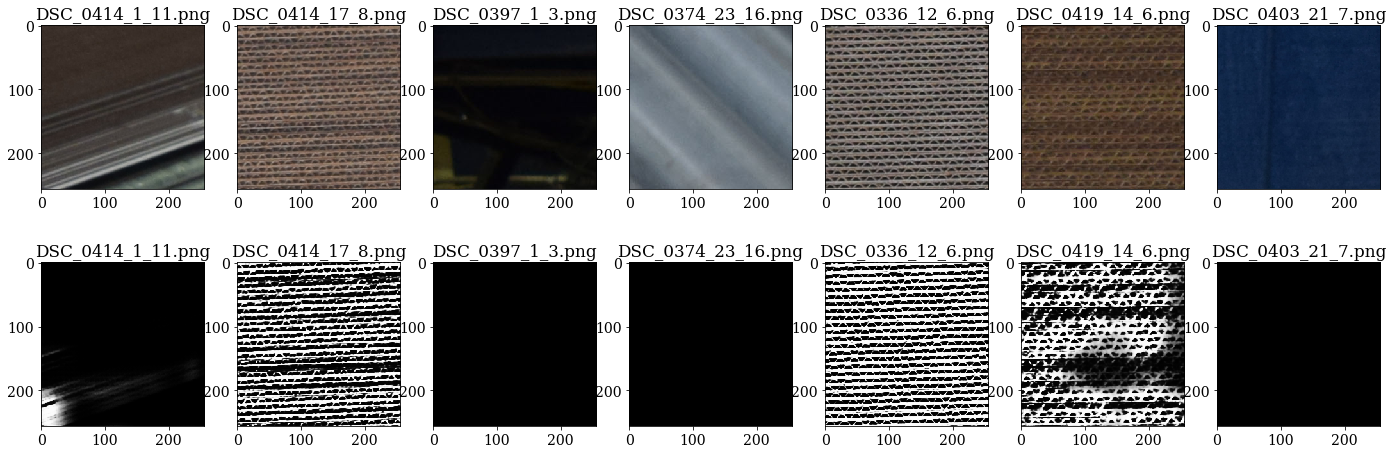

In [117]:
# randomly show some predicted results
train_test_path = "D:/carboardin/"
train_pred_path = 'D:/carboardout/'
 
image_array = []
 
for root, dirs, files in os.walk(train_test_path): 
    image_array = files

col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(image_array)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(24,8))  
 
for row in range(0,row_size): 
    image_index = 0
    if (row==0): 
        da_path= train_test_path
    else: 
        da_path= train_pred_path
 
    for col in range(0,col_size):
        img = load_img(da_path+image_array[rand_id_array[image_index]])
        ax[row][col].imshow(img)
        ax[row][col].set_title(image_array[rand_id_array[image_index]])
        image_index += 1
plt.show()

In [129]:
#create some foder to combine all chunks back to one image
import os
import shutil
path = 'D:/Out01/'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path) # Removes all the subdirectories!
    os.makedirs(path)
    
os.mkdir('D:/Out01/test01')
os.mkdir('D:/Out01/test02')
os.mkdir('D:/Out01/test03')
os.mkdir('D:/Out01/test04')
os.mkdir('D:/Out01/test05')
os.mkdir('D:/Out01/test06')
os.mkdir('D:/Out01/test07')
os.mkdir('D:/Out01/test08')

In [135]:
# filelist=['DSC_0324','DSC_0326','DSC_0336','DSC_0374','DSC_0397','DSC_0400','DSC_0403','DSC_0414','DSC_0419','DSC_0435']
# make the filelist for all testing images
os.chdir('D:/image')
list_im = os.listdir('D:/image')
filelist=[i.split('.')[0] for i in list_im]

In [181]:
pic='DSC_0435'

In [145]:
# filelist=['DSC_0324','DSC_0326','DSC_0336','DSC_0374','DSC_0397','DSC_0400','DSC_0403','DSC_0414','DSC_0419','DSC_0435']
import shutil
os.chdir('D:/carboardout')
list_im = os.listdir('D:/carboardout')
for i in list_im:
    filename='_'.join([i.split('_')[0],i.split('_')[1]])
    if filename == pic:
        shutil.copy2('D:/carboardout/'+str(i), 'D:/Out01/test08/' ) # target filename is D:/Out01/test08/

In [146]:
import cv2
import numpy as np
import imageio
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
import scipy.misc
import scipy
import image_slicer
from image_slicer import join
from PIL import Image
import numpy as np
import PIL

In [147]:
os.chdir('D:/Out01/test08')
list_im = os.listdir('D:/Out01/test08')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
dim=set([ i.split('_')[2] for i in list_im])

list=[i.split('.')[0] for i in list_im]

list1=sorted(list,key=lambda x:(int(x.split('_')[2]),int(x.split('_')[3])))
# Have to sort the picture, otherwise will get wrong order pictures
for j in range(1,len(dim)+1):
    imgs=[]
    for i in list1:
        if i.split('_')[2]==str(j):
            img = PIL.Image.open(i+'.png')
            imgs.append(img)
            # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
            min_shape = sorted( [(np.sum(h.size), h.size ) for h in imgs])[0][1]
            # for a vertical stacking it is simple: use vstack
            imgs_comb = np.vstack((np.asarray( t.resize(min_shape) ) for t in imgs ))
            imgs_comb = PIL.Image.fromarray( imgs_comb)
            imgs_comb.save( 'D:/Out01/test03/'+filename+ str(j)+'.png' )           


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [148]:
os.chdir('D:/Out01/test03')
list_im = os.listdir('D:/Out01/test03')
list=[i.split('.')[0] for i in list_im]
list1=sorted(list,key=lambda x:int(x.split('_')[1]))
imgs = [ PIL.Image.open(i+'.png') for i in list1 ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(h.size), h.size ) for h in imgs])[0][1]
# for a horizontal  stacking it is simple: use hstack
imgs_comb = np.hstack((np.asarray( t.resize(min_shape) ) for t in imgs ))
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test04/'+filename+'.png' )  

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


In [182]:
from math import remainder
remainder(4000,256)
import cv2
image = cv2.imread('D:/unet4paper/cardboard/predict/image/'+pic+'.png')
size_x = image.shape[1]
size_y = image.shape[0]
w=256*(size_x//256)
h=256*(size_y//256)
dx=size_x - w
dy=size_y - h
dx,dy


(2, 160)

In [183]:
# Remove the overlap for horizontal
import cv2
import os

dirpath = 'D:/Out01/test04/'
destDirectory = 'D:/Out01/test05/'
for file in os.listdir(dirpath):
    image = cv2.imread(os.path.join(dirpath, file))
    #image = cv2.imread(os.path.join(dirpath, file), cv2.IMREAD_GRAYSCALE)
    size = image.shape[1]
    s_thresh = image[:, (size-dx):size]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(2) + '.png', s_thresh)

    s_thresh = image[:, 0:w]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(1) + '.png', s_thresh)


In [184]:
# Remove the overlap for horizontal
os.chdir('D:/Out01/test05')
list_im = os.listdir('D:/Out01/test05')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
imgs = [ PIL.Image.open(i) for i in list_im ]
# for a horizontal  stacking it is simple: use hstack
imgs_comb = np.hstack( (np.asarray( t ) for t in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test06/'+filename+'.png') 

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


In [185]:
# Remove the overlap for vetical
import cv2
import os
dirpath = 'D:/Out01/test06/'
destDirectory = 'D:/Out01/test07/'
for file in os.listdir(dirpath):
    image = cv2.imread(os.path.join(dirpath, file))
    #image = cv2.imread(os.path.join(dirpath, file), cv2.IMREAD_GRAYSCALE)
    size = image.shape[0]
    s_thresh = image[(size-dy):size,:]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(2) + '.png', s_thresh)

    s_thresh = image[0:h,:]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(1) + '.png', s_thresh)


In [186]:
# Remove the overlap for vetical
os.chdir('D:/Out01/test07')
list_im = os.listdir('D:/Out01/test07')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
imgs = [ PIL.Image.open(i) for i in list_im ]
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( t ) for t in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test01/'+filename+'.png') 

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
